# NewRad2023

In [20]:
import numpy as np
import luxpy as lx
from luxpy import _CIE_ILLUMINANTS, SPD, _CMF
from empir19nrm02 import _SPD, _RES

from empir19nrm02.tools.help import strd, label_font_size, plot_cmf2, save_fig, get_target, label_management, \
    quantil, display_responsivity
from empir19nrm02.MC import load_from_csv, load_from_excel, MCVectorVar, NameUnit, DistributionParam, MCSimulation,noise_list_default
from empir19nrm02.spectral.spectral_data import _CORR_PATH
from empir19nrm02.tools import plotHistScales, plotHistGauss, plot_2D, get_data_step, seaborn_plot_result_gen, plotCorrelation
from matplotlib import pyplot
from empir19nrm02.MC import StatDataVector

## Some settings for the processing

In [21]:
# Calibration illuminant
S_C = 'A'
#S_C = 'L41'
print( 'Calibration with: ', S_C)

# Select the color space for evaluation
cieobs = '1931_2'
print('Color matching functions from:', cieobs)

# display the colorbar in some diagrams
spectrum_color = False

# outdir
out_dir = 'NewRad2023'

Calibration with:  A
Color matching functions from: 1931_2
Calibration with:  A
Color matching functions from: 1931_2


## The Detector for the NewRad article is included in the general list with #128
### Load here without any uncertainty information

VLDetectors


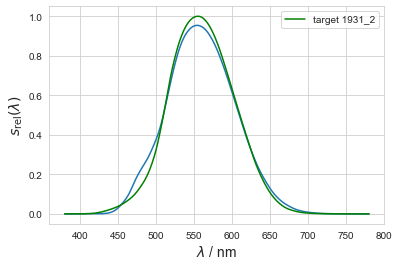

f1prime=7.3 %
VLDetectors


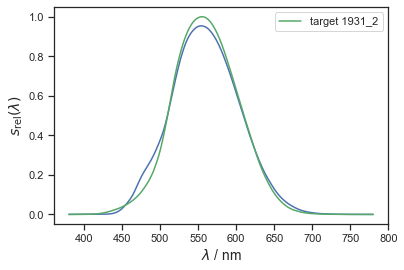

f1prime=7.3 %


In [22]:
_detectors=_RES['VLDetectors']['S']['data'].copy()
# the detector from Yasaman (eMail: 230317)
det_number = 128
detector_tmp = np.vstack((_detectors[0], _detectors[det_number]))

# wavelength scale for further use
wl = lx.getwlr((380,780,1))

detector = lx.cie_interp(detector_tmp, wl, kind='S')
detector_norm, f1p = display_responsivity('VLDetectors', detector, cieobs=cieobs, s_target_index=2, out_dir=out_dir, S_C=S_C, spectrum_color=spectrum_color, plots=['plot1'])
print( f'f1prime={f1p[0]*100:0.2} %')

## A more general way to caculate SMCF
# $F(S_\mathrm{Z}(\lambda),S_\mathrm{C}(\lambda) = \frac{F_\mathrm{C,N}}{F_\mathrm{C,D}}\frac{F_\mathrm{M,N}}{F_\mathrm{M,D}}$

# $F_\mathrm{C,N} = \int{S_\mathrm{C}(\lambda)s(\lambda)\mathrm{d}\lambda}$
# $F_\mathrm{C,D} = \int{S_\mathrm{C}(\lambda)s_\mathrm{T}(\lambda)\mathrm{d}\lambda}$
# $F_\mathrm{M,N} = \int{S_\mathrm{Z}(\lambda)s_\mathrm{T}(\lambda)\mathrm{d}\lambda}$
# $F_\mathrm{M,D} = \int{S_\mathrm{Z}(\lambda)s(\lambda)\mathrm{d}\lambda}$

# $F(S_\mathrm{Z}(\lambda),S_\mathrm{C}(\lambda) = \underbrace{\frac{\int{S_\mathrm{C}(\lambda)s(\lambda)\mathrm{d}\lambda}}{\int{S_\mathrm{C}(\lambda)s_\mathrm{T}(\lambda)\mathrm{d}\lambda}}}_{\text{Calibration}}\underbrace{\frac{\int{S_\mathrm{Z}(\lambda)s_\mathrm{T}(\lambda)\mathrm{d}\lambda}}{\int{S_\mathrm{Z}(\lambda)s(\lambda)\mathrm{d}\lambda}}}_{\text{Measurement}}$

| Symbol | Description |
| :-:    |  :-:   |
| $F(S_\mathrm{Z}(\lambda)$ | SD DUT |
| $F(S_\mathrm{C}(\lambda)$ | SD Calibration |
| $s(\lambda)$ | (rel.) spectral responsivity of detetor |
| $s_\mathrm{T}(\lambda)$ |  spectral responsivity of the target function (e.g. $V(\lambda)$ |


In [23]:
g_S_C_ref = None
g_S_Z_ref = None
g_s_detector_ref = None

def smcf_set_ref( _S_C_ref, _S_Z_ref, _s_detector_ref):
    global g_S_C_ref, g_S_Z_ref, g_s_detector_ref

    if isinstance(_S_C_ref,str):
        g_S_C_ref = _CIE_ILLUMINANTS[_S_C_ref].copy()
    else:
        if isinstance(_S_C_ref, SPD):
            g_S_C_ref = np.vstack( (_S_C_ref.wl, _S_C_ref.value))
        else:
            g_S_C_ref = _S_C_ref.copy()

    if isinstance(_S_Z_ref,str):
        g_S_Z_ref = _CIE_ILLUMINANTS[_S_Z_ref].copy()
    else:
        if isinstance(_S_Z_ref, SPD):
            g_S_Z_ref = np.vstack( (_S_Z_ref.wl, _S_Z_ref.value))
        else:
            g_S_Z_ref = _S_Z_ref.copy()
    if isinstance(_S_Z_ref, SPD):
        g_s_detector_ref = np.vstack( (_s_detector_ref.wl, _s_detector_ref.value))
    else:
        g_s_detector_ref = _s_detector_ref.copy()
    return

def smcf_calculation( S_Z, s_detector, S_C='A', cieobs='1931_2', s_target_index=2, interp_kind = 'S', use_ref = False, use_global_ref = False):

    # Get illuminant:
    if isinstance(S_C,str): S_C = _CIE_ILLUMINANTS[S_C].copy()

    s_target = _CMF[cieobs]['bar'][[0,s_target_index]].copy() if isinstance(cieobs, str) else cieobs[[0,s_target_index]].copy()

    wlr = s_detector[0] # get wavelength range from the detector data
    dl = lx.getwld(wlr) # wavelength differences (unequal wavelength spacings are taken into account)
    dl = dl*np.ones_like(wlr) # ensure array like for matrix multiplication

    # Interpolate measured spectrum to desired wavelength range:
    s_target = lx.cie_interp(s_target, wlr, kind = interp_kind)[1:]
    S_C = lx.cie_interp(S_C, wlr, kind = interp_kind)[1:]
    S_Z = lx.cie_interp(S_Z, wlr, kind = interp_kind)[1:]
    s_detector = s_detector[1:]

    # taking the first information as reference
    if use_ref:
        if use_global_ref:
            S_C_ref = lx.cie_interp(g_S_C_ref, wlr, kind = interp_kind)[1:]
            S_Z_ref = lx.cie_interp(g_S_Z_ref, wlr, kind = interp_kind)[1:]
            s_detector_ref = lx.cie_interp(g_s_detector_ref, wlr, kind = interp_kind)[1:]
            S_C_ref = np.tile(S_C_ref[0],(S_C.shape[0],1))
            S_Z_ref = np.tile(S_Z_ref[0],(S_Z.shape[0],1))
            s_detector_ref = np.tile(s_detector_ref[0],(s_detector.shape[0],1))
        else:
            S_C_ref = np.tile(S_C[0],(S_C.shape[0],1))
            S_Z_ref = np.tile(S_Z[0],(S_Z.shape[0],1))
            s_detector_ref = np.tile(s_detector[0],(s_detector.shape[0],1))
    else:
        S_C_ref = S_C
        S_Z_ref = S_Z
        s_detector_ref = s_detector

    use_luxpy = False
    F_M_N = 1
    F_M_D = 1
    F_C_N = 1
    F_C_D = 1
    if use_luxpy:
        # Calculate s_rel:
        s_rel = (s_target @ (S_C_ref*dl).T) / (s_detector_ref @ (S_C*dl).T) * s_detector
        # Calculate spectral mismatch correction factors:
        F = (S_Z_ref @ (s_target*dl).T) / (S_Z @ (s_rel*dl).T)
    else:
        # Calculate spectral mismatch correction factors:
        F_M_N = (S_Z_ref @ (s_target*dl).T)
        F_M_D = (S_Z @ (s_detector*dl).T)
        F_C_N = (S_C @ (s_detector_ref*dl).T)
        F_C_D = (S_C_ref @ (s_target*dl).T)
        F = F_C_N/F_C_D * F_M_N/F_M_D

    return F, F_C_N, F_C_D, F_M_N, F_M_D

In [24]:
def plotMCResult( wl, mcVarData:StatDataVector, title=None, fig = None, ax1 = None, ax2 = None, diagnumber=0):
    bFirst = False
    if not fig:
        fig, ax1 = pyplot.subplots()
        ax2 = ax1.twinx()
        color1 = 'r-'
        color2 = 'g-'
    else:
        if diagnumber == 1:
            color1 = 'r--'
            color2 = 'g--'
        else:
            color1 = 'r-.'
            color2 = 'g-.'

    if not title:
        title = ''
    ax1.plot(wl, mcVarData.v_mean/np.max(mcVarData.v_mean), color1, label= title + ' $s_{\mathrm{rel}}(\lambda)$')
    ax2.plot(wl,mcVarData.v_std / mcVarData.v_mean, color2, label= title + ' $u_{\mathrm{rel}}(s_{\mathrm{rel}})(\lambda)$')
    ax1.set_xlabel(strd['xlambda'])
    ax1.set_ylabel('Signal / A.U', color = 'red')
    ax2.set_ylabel('$\sigma_{\mathrm{rel}}$', color = 'green')
    if title:
        ax1.set_title(title)
    fig.legend()
    return fig, ax1, ax2

# Use FEL Lamp-1 from the PTB set

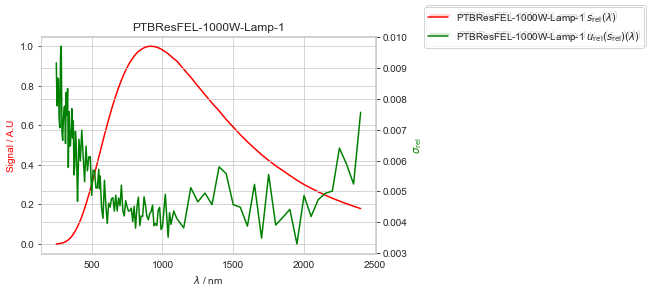

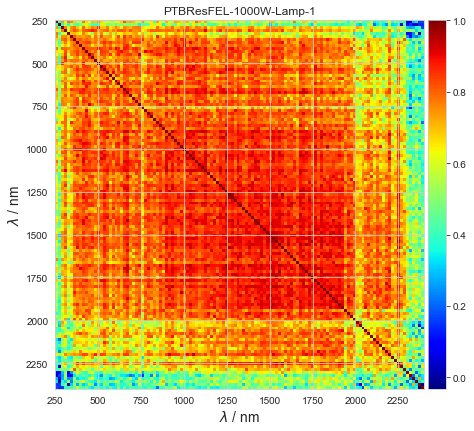

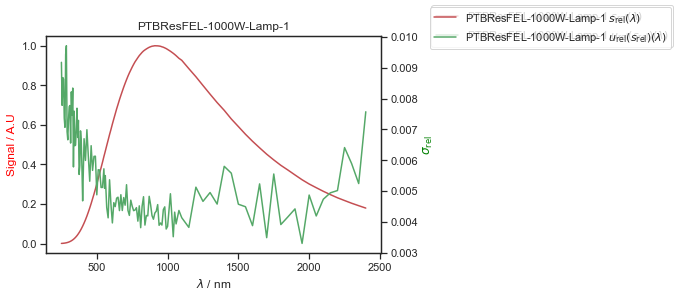

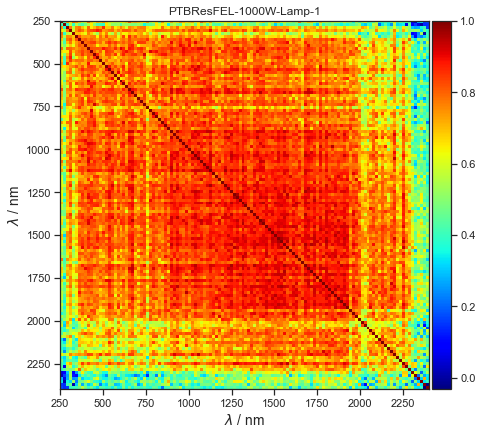

In [25]:
str_FEL_file = 'PTBResFEL-1000W-Lamp-1'
wlFEL, mcVectorVarFEL = load_from_csv(_CORR_PATH + '/' + str_FEL_file)
mcVectorVarFEL.name = NameUnit( str_FEL_file, 'A.U.')

fig, ax1, ax2 = plotMCResult(wlFEL, mcVectorVarFEL.setData, str_FEL_file)
fig.legend(bbox_to_anchor=(1,1), loc="upper left")
plotCorrelation(mcVectorVarFEL.setData.corr_matrix, wlFEL, str_FEL_file)

## Interpolate the lamp data to the wl scale of the simulation

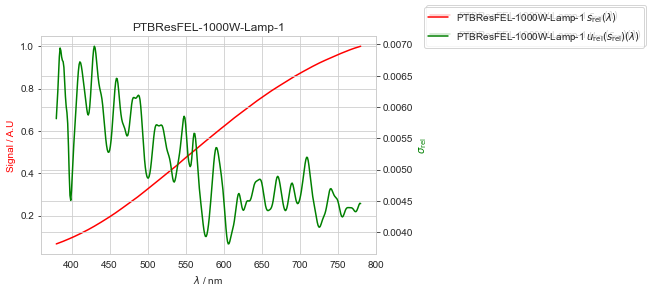

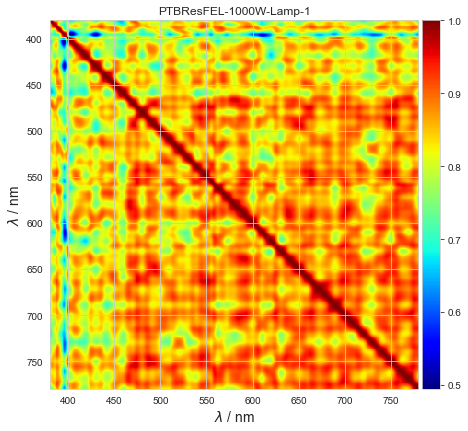

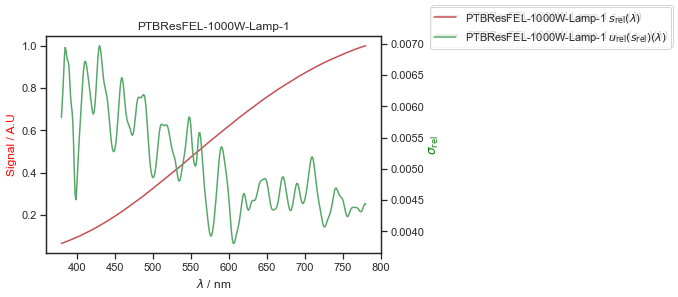

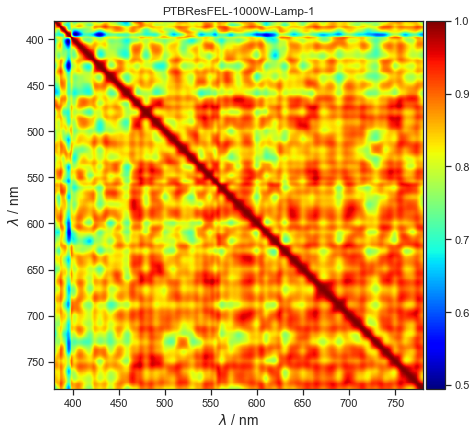

In [26]:
# put the data at the same WL-Scale
if len(wl) != mcVectorVarFEL.elements:
    mcVectorVarFEL.interpolate(wl, wlFEL, trials=100000)

fig, ax1, ax2 = plotMCResult(wl, mcVectorVarFEL.setData, str_FEL_file)
fig.legend(bbox_to_anchor=(1,1), loc="upper left")
save_fig(out_dir, 'FEL_SDi')

plotCorrelation(mcVectorVarFEL.setData.corr_matrix, wl, str_FEL_file)
save_fig(out_dir, 'FEL_Corri')

_spectra = np.vstack((wl, mcVectorVarFEL.setData.v_mean))

## Use Photometer information from PTB Data (only the uncertainty, the spectral responsivity is taken from #128)

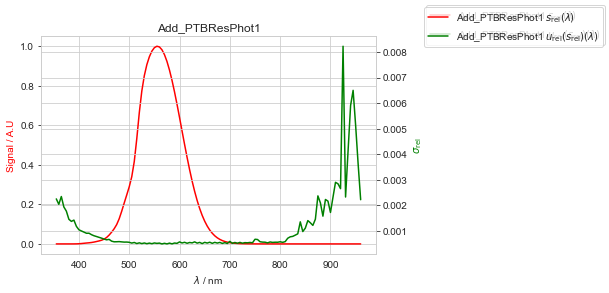

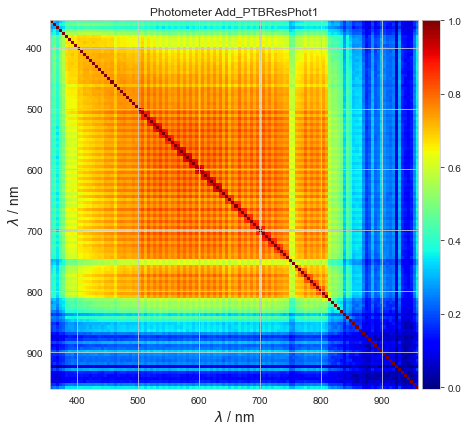

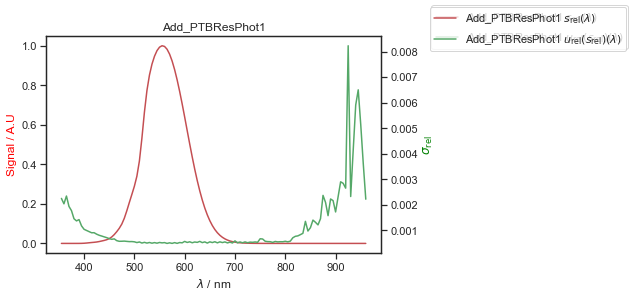

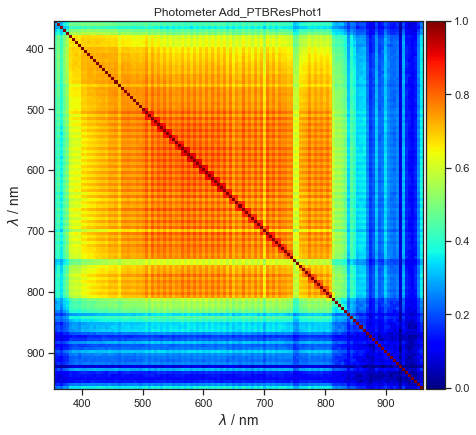

In [27]:
str_Phot_file = 'Add_PTBResPhot1'
wlPhot, mcVarDetector = load_from_excel(filename = _CORR_PATH + '/' + str_Phot_file, wlColumn = 1, valColumn=2, stdColumn = 3, covColumn=None, corrColumn = 4, startRow=2)
mcVarDetector.name = NameUnit( str_Phot_file, 'A.U.')

fig, ax1, ax2 = plotMCResult(wlPhot, mcVarDetector.setData, title=str_Phot_file)
fig.legend(bbox_to_anchor=(1,1), loc="upper left")

plotCorrelation(mcVarDetector.setData.corr_matrix, wlPhot, 'Photometer ' + str_Phot_file)

## Interpolate the photometer data to the wl scale of the simulation

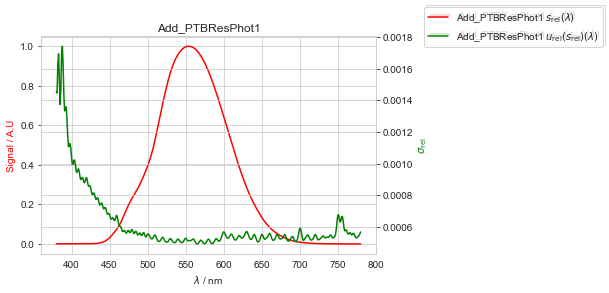

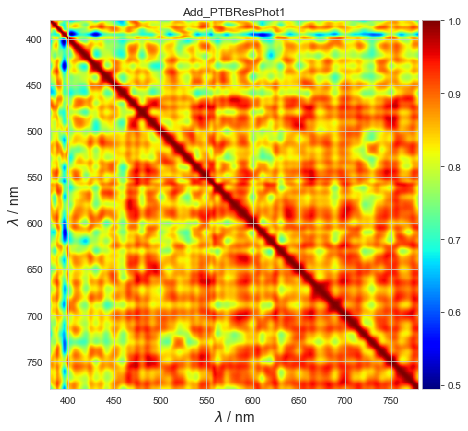

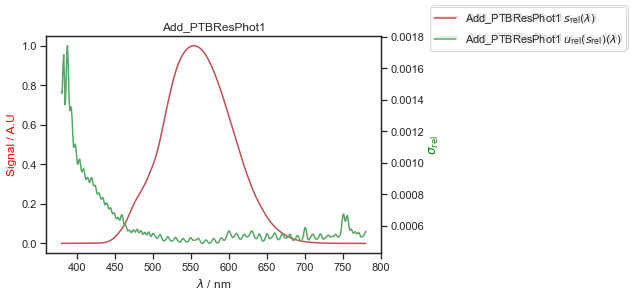

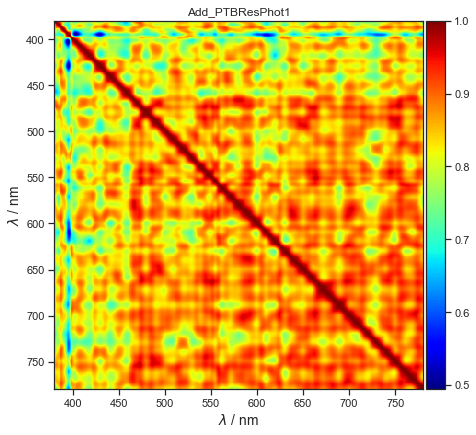

In [28]:
# put the data at the same WL-Scale
if len(wl) != mcVarDetector.elements:
    mcVarDetector.interpolate(wl, wlPhot, trials=100000)

# hold the relative standard deviation constant
v_std_rel = mcVarDetector.setData.v_std/mcVarDetector.setData.v_mean

# Use the mean value from detector #128 (hold the uncertainty data from the PTB measurements)
mcVarDetector.set_vector_param( detector[1], v_std=v_std_rel*detector[1], corr=mcVarDetector.setData.corr_matrix)

fig, ax1, ax2 = plotMCResult(wl, mcVarDetector.setData, str_Phot_file)
fig.legend(bbox_to_anchor=(1,1), loc="upper left")
save_fig(out_dir, 'Phot_SDi')

plotCorrelation(mcVectorVarFEL.setData.corr_matrix, wl, str_Phot_file)
save_fig(out_dir, 'Phot_Corri')

_detector = np.vstack((wl, mcVarDetector.setData.v_mean))


In [29]:
SMCF_A = lx.spectral_mismatch_and_uncertainty.get_spectral_mismatch_correction_factors( _spectra, _detector, S_C='A', cieobs='1931_2', s_target_index=2)
print( f'SMCF for calibration with standard illuminant A: {SMCF_A[0][0]:.6}')
SMCF_L41 = lx.spectral_mismatch_and_uncertainty.get_spectral_mismatch_correction_factors( _spectra, _detector, S_C='L41', cieobs='1931_2', s_target_index=2)
print( f'SMCF for calibration with standard illuminant L41: {SMCF_L41[0][0]:.6}')

SMCF for calibration with standard illuminant A: 1.00049
SMCF for calibration with standard illuminant L41: 0.984236
SMCF for calibration with standard illuminant A: 1.00049
SMCF for calibration with standard illuminant L41: 0.984236


# Check the more general SMCF calculation

In [30]:
F, F_C_N, F_C_D, F_M_N, F_M_D = smcf_calculation( _spectra, _detector, S_C='A', cieobs='1931_2', s_target_index=2)
print(f'CIE standard illuminant A: {F}, {F_C_N}, {F_C_D}, {F_M_N}, {F_M_D} --> reduced: {F_M_N/F_M_D}')

F, F_C_N, F_C_D, F_M_N, F_M_D = smcf_calculation( _spectra, _detector, S_C='L41', cieobs='1931_2', s_target_index=2)
print(f'CIE reference source L41: {F}, {F_C_N}, {F_C_D}, {F_M_N}, {F_M_D} --> reduced: {F_M_N/F_M_D}')


CIE standard illuminant A: [[1.0005e+00]], [[1.1313e+04]], [[1.0790e+04]], [[5.0612e+00]], [[5.3042e+00]] --> reduced: [[9.5418e-01]]
CIE reference source L41: [[9.8424e-01]], [[1.5102e+03]], [[1.4641e+03]], [[5.0612e+00]], [[5.3042e+00]] --> reduced: [[9.5418e-01]]
CIE standard illuminant A: [[1.0005e+00]], [[1.1313e+04]], [[1.0790e+04]], [[5.0609e+00]], [[5.3040e+00]] --> reduced: [[9.5418e-01]]
CIE reference source L41: [[9.8424e-01]], [[1.5102e+03]], [[1.4641e+03]], [[5.0609e+00]], [[5.3040e+00]] --> reduced: [[9.5418e-01]]


# MCS

In [31]:
trials = 20000

def runSimpleMC( spectraMC, detectorMC, SMCF, NumberTrials, model_single):
    input = [spectraMC, detectorMC]
    output = [SMCF]

    sim = MCSimulation(trials=NumberTrials)
    sim.set_input_var(input)
    sim.set_output_var(output)
    sim.generate()
    sim.calculate_model( model_single)
    return sim.output_var, sim.get_result_db()

def model_single(spectra, detector):
    spectmp = np.vstack( (wl, spectra) )
    detectortmp = np.vstack( (wl, detector) )
    SMCF_g, F_C_N, F_C_D, F_M_N, F_M_D = smcf_calculation( spectmp, detectortmp, S_C='A', cieobs='1931_2', s_target_index=2, use_ref=False, use_global_ref=False)
    #print(f'{SMCF_g[0][0]}, {F_C_N[0][0]}, {F_C_D[0][0]}, {F_M_N[0][0]}, {F_M_D[0][0]} --> reduced: {F_M_N[0][0]/F_M_D[0][0]}')
    SMCF_a = np.zeros(7)
    SMCF_a[0] = SMCF_g[0][0]
    SMCF_a[1] = F_C_N[0][0]
    SMCF_a[2] = F_C_D[0][0]
    SMCF_a[3] = F_M_N[0][0]
    SMCF_a[4] = F_M_D[0][0]
    SMCF_a[5] = F_C_N[0][0] / F_C_D[0][0]
    SMCF_a[6] = F_M_N[0][0] / F_M_D[0][0]
    return [SMCF_a]

In [32]:
def get_name(i:int)->str:
    return mcResult_db['Input'].values[i]

column_str_MC = ['F','F_{\mathrm{C,N}}','F_{\mathrm{C,D}}','F_{\mathrm{{M,N}}','F_{\mathrm{M,D}}','F_{\mathrm{C}}','F_{\mathrm{M}}']
def get_item_name(i:int, use_math = True)->str:
    if use_math:
        return '$' + column_str_MC[i] + '$'
    else:
        return column_str_MC[i]

In [33]:
# run the MCS

# define the results (SMCF, the single integrals and the ratios from calibration and measurement)
SMCF_MC = MCVectorVar( name = NameUnit(column_str_MC, ['' for _ in column_str_MC]), elements=len(column_str_MC))

mcResult, mcResult_db = runSimpleMC( mcVectorVarFEL, mcVarDetector, SMCF_MC, trials, model_single)
mcResult_db

Generate:


,Input,Unit,Mean,StdDev,Distr,F,u(F),"F_{\mathrm{C,N}}","u(F_{\mathrm{C,N}})","F_{\mathrm{C,D}}","u(F_{\mathrm{C,D}})","F_{\mathrm{{M,N}}","u(F_{\mathrm{{M,N}})","F_{\mathrm{M,D}}","u(F_{\mathrm{M,D}})",F_{\mathrm{C}},u(F_{\mathrm{C}}),F_{\mathrm{M}},u(F_{\mathrm{M}})
0,PTBResFEL-1000W-Lamp-1,A.U.,0.05002378,0.00022769,normal,1.00000002,0.00002776,"11,313.13835237",0.00000000,"10,789.50755552",0.00000000,5.06125723,0.02310877,5.30429523,0.02424276,1.04853148,0.00000000,0.95418093,0.00002649
0,Add_PTBResPhot1,A.U.,0.28028599,0.00014705,normal,1.00000000,0.00000246,"11,313.13842133",5.32636639,"10,789.50755552",0.00000000,5.06125701,0.00000000,5.30429503,0.00249698,1.04853149,0.00049366,0.95418111,0.00044918
0,All,,,,,1.00000002,0.00002786,"11,313.13842133",5.32636639,"10,789.50755552",0.00000000,5.06125723,0.02310877,5.30429521,0.02435894,1.04853149,0.00049366,0.95418113,0.00044992


Generate:


,Input,Unit,Mean,StdDev,Distr,F,u(F),"F_{\mathrm{C,N}}","u(F_{\mathrm{C,N}})","F_{\mathrm{C,D}}","u(F_{\mathrm{C,D}})","F_{\mathrm{{M,N}}","u(F_{\mathrm{{M,N}})","F_{\mathrm{M,D}}","u(F_{\mathrm{M,D}})",F_{\mathrm{C}},u(F_{\mathrm{C}}),F_{\mathrm{M}},u(F_{\mathrm{M}})
0,PTBResFEL-1000W-Lamp-1,A.U.,0.05002378,0.00022769,normal,1.00000002,0.00002791,"11,313.16022246",0.00000000,"10,789.50755552",0.00000000,5.06098716,0.02316561,5.30402206,0.02430117,1.04853351,0.00000000,0.95417915,0.00002663
0,Add_PTBResPhot1,A.U.,0.28028599,0.00014622,normal,1.00000000,0.00000244,"11,313.16041454",5.28478608,"10,789.50755552",0.00000000,5.06098691,0.00000000,5.30402190,0.00247723,1.04853353,0.00048981,0.95417932,0.00044565
0,All,,,,,1.00000002,0.00002802,"11,313.16041454",5.28478608,"10,789.50755552",0.00000000,5.06098716,0.02316561,5.30402222,0.02444294,1.04853353,0.00048981,0.95417934,0.00044630


Value= [0.9541809265831753, 2.6490292874048278e-05] Inteval(95%)= 0.0001049282593964529 U= 5.246412969822645e-05
Value= [0.9541811121521856, 0.0004491752323242062] Inteval(95%)= 0.0017764600657305119 U= 0.0008882300328652559
Value= [0.9541811319679647, 0.0004499175676506984] Inteval(95%)= 0.0017773085313603776 U= 0.0008886542656801888


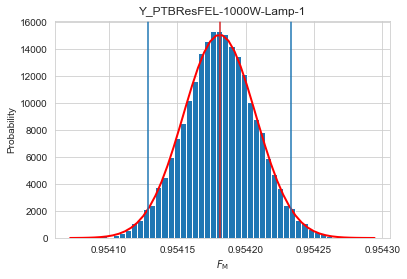

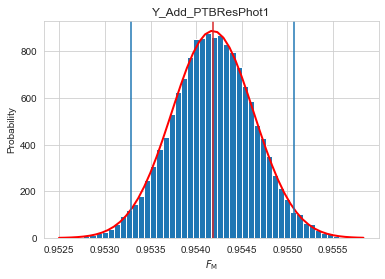

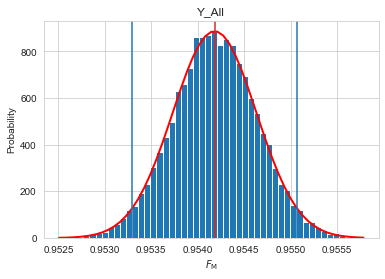

Value= [0.954179151478437, 2.662795890154509e-05] Inteval(95%)= 0.00010493008455059183 U= 5.2465042275295914e-05
Value= [0.9541793221374801, 0.0004456467845980196] Inteval(95%)= 0.0017488454557641475 U= 0.0008744227278820738
Value= [0.9541793431803895, 0.00044630322415119766] Inteval(95%)= 0.001750422413720587 U= 0.0008752112068602935


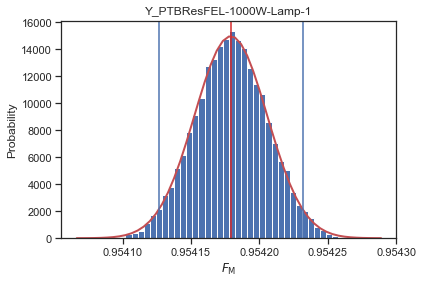

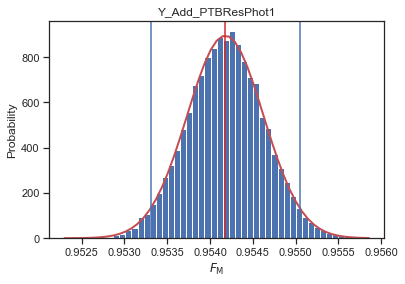

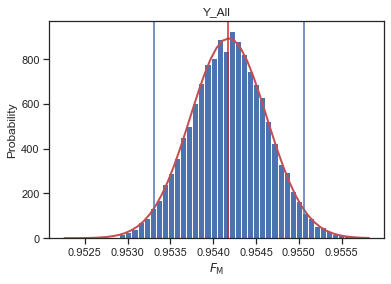

In [34]:
j_observation = 6
for i in range(2+1):
    var = mcResult[i]
    plotHistScales( var[0].val[:,j_observation], add_distribution=True, title='Y_'+get_name(i), xLabel=get_item_name(j_observation))


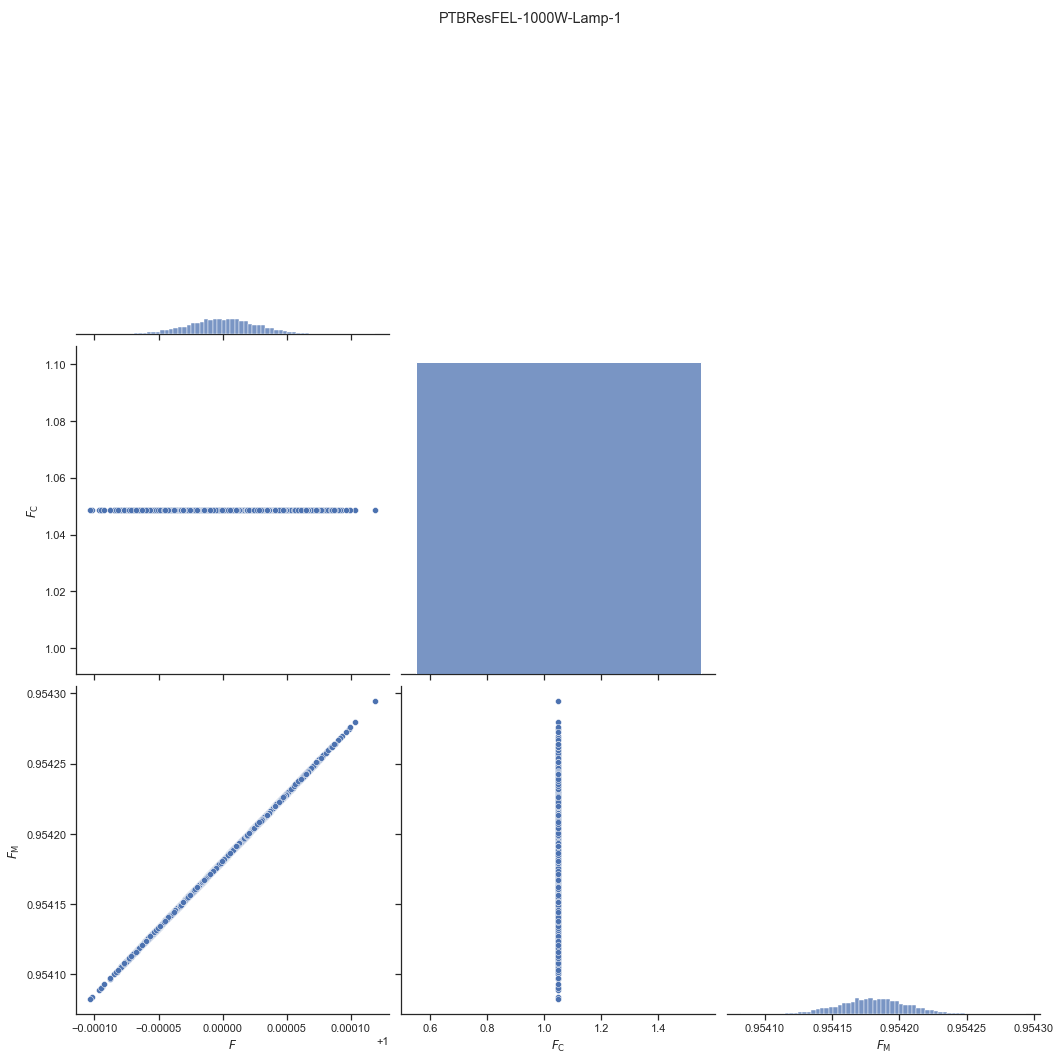

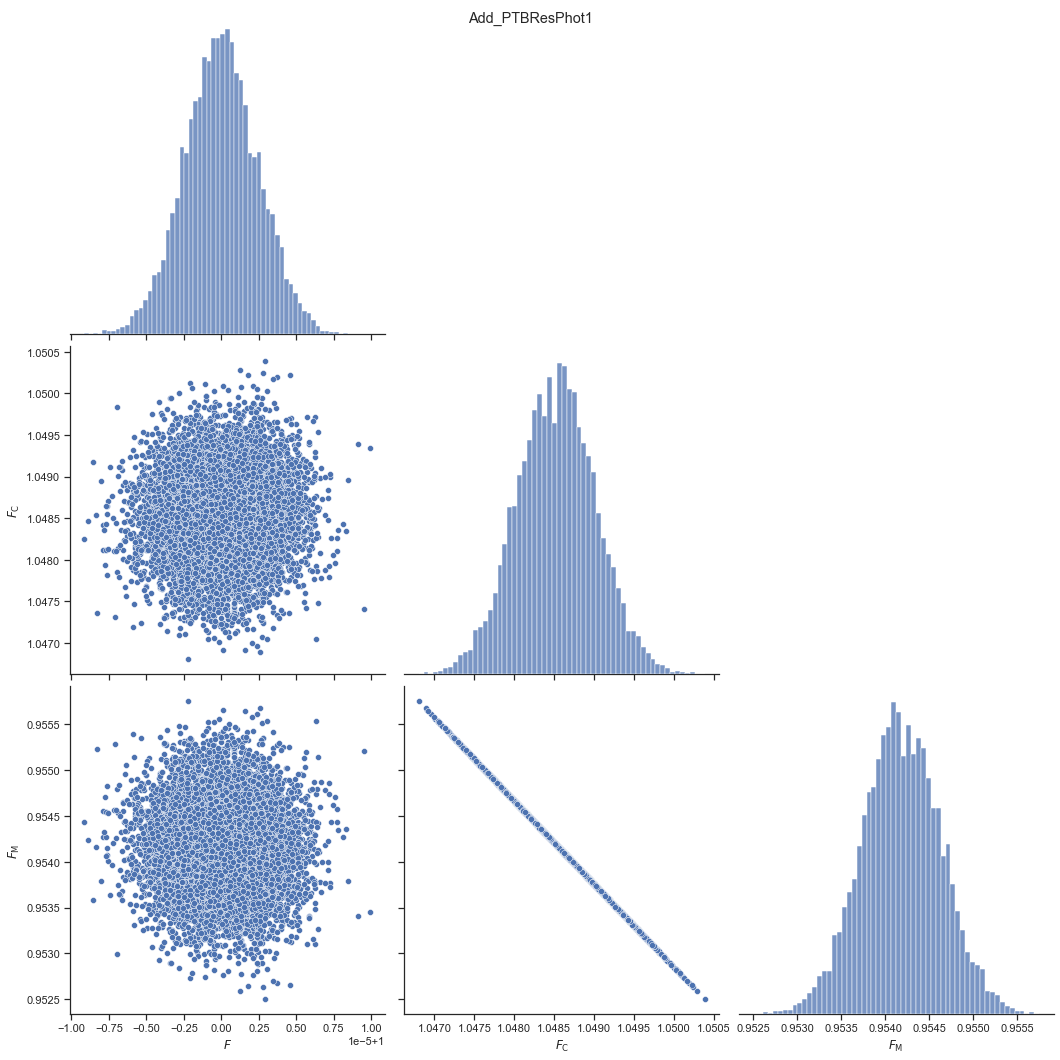

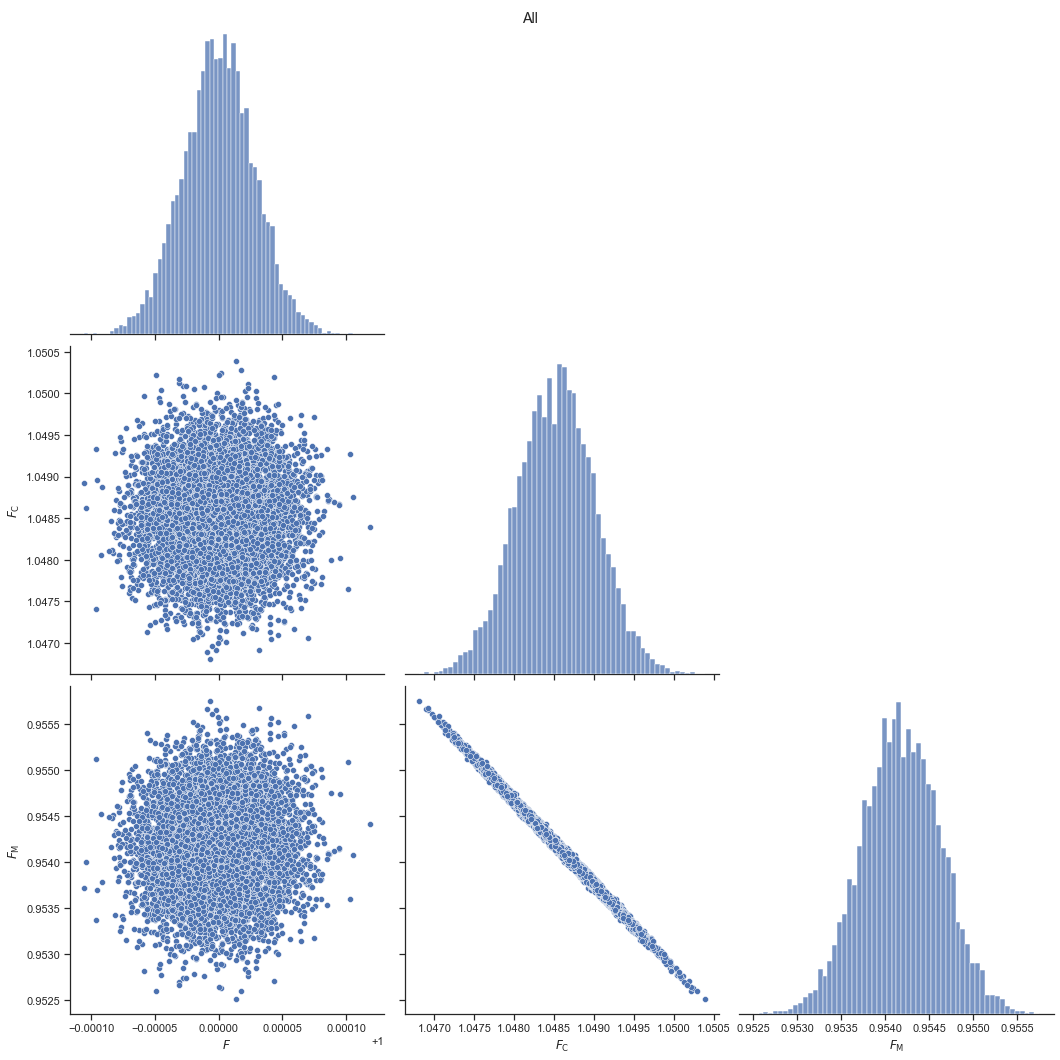

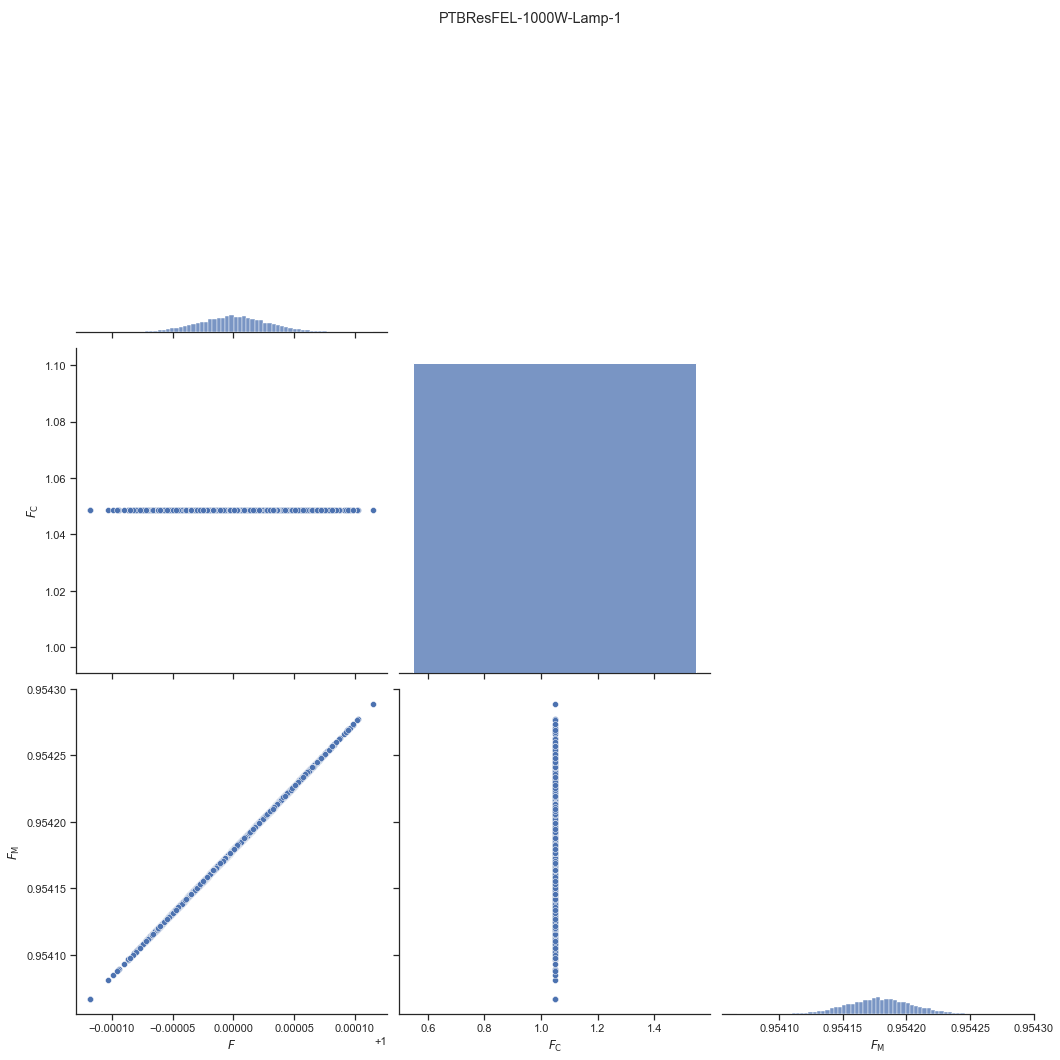

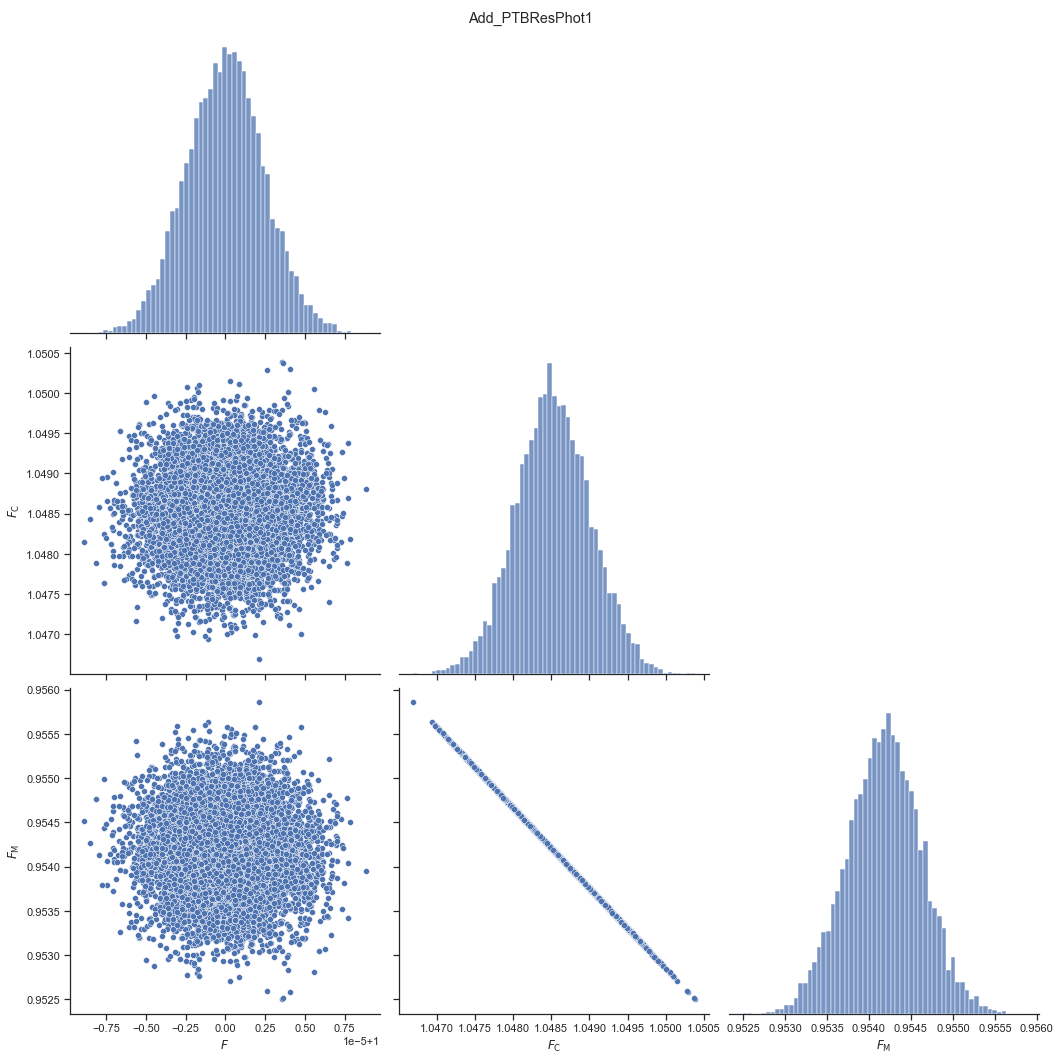

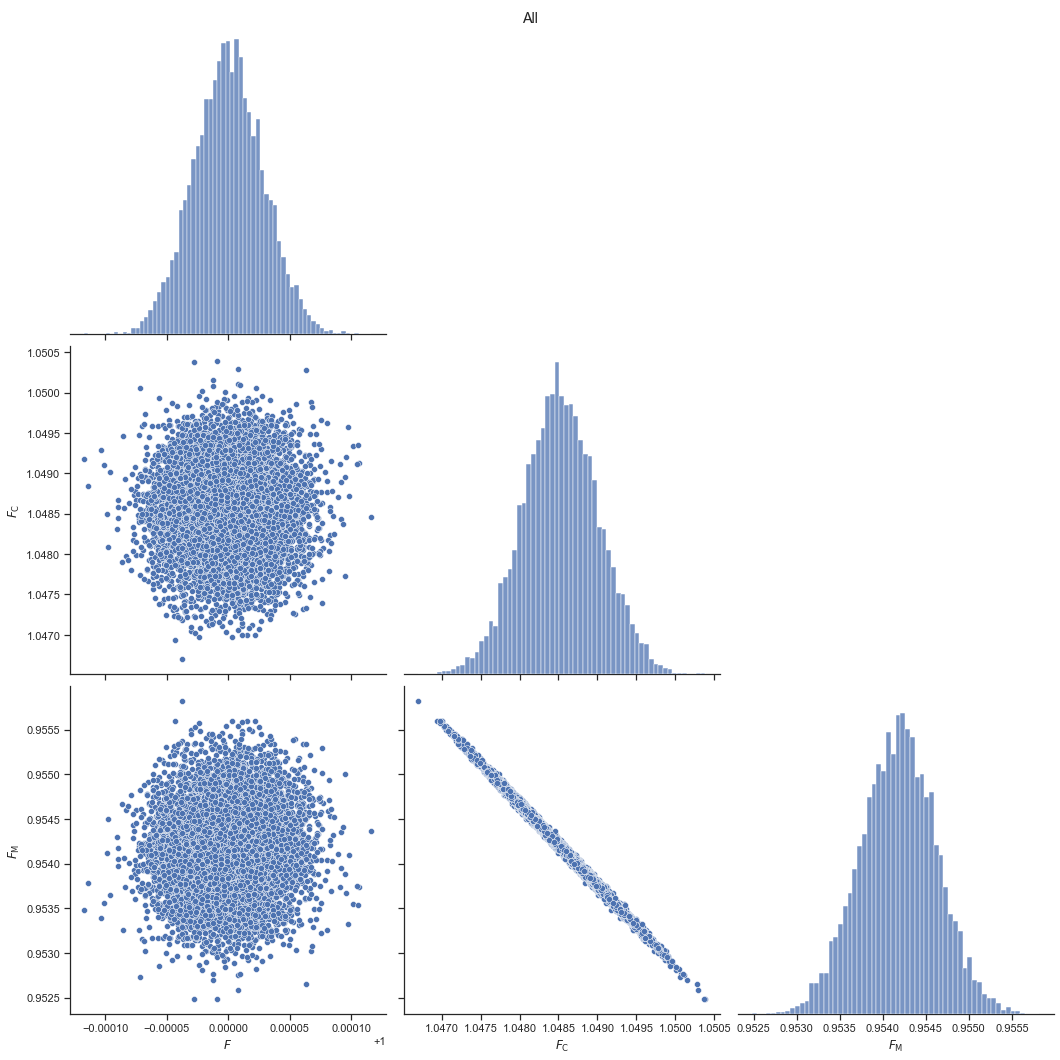

In [35]:
# use selected data only (F, F_C and F_M)
display_list = [0, 5, 6]
for i in range(2+1):
    var = mcResult[i][0].val.T
    seaborn_plot_result_gen(
        np.vstack([var[display_list[_j]] for _j in range(len(display_list))]),
        display=['n' for _ in range(len(display_list))], dim=len(display_list),
        column_str=[get_item_name(display_list[_i], use_math=False) for _i in range(len(display_list))], title=get_name(i))

In [36]:
from empir19nrm02.MC import generate_base_functions
import pandas as pd
from empir19nrm02.tools import sumMC
elements2Run = [0,1,2,3,4,5,6,7,8,9,10,20,30,40,47, 50,60,70,80,90,100,150,200,235]

def FourierTableSMCF( trials, wl, SD, uSD, Detector, uDetector, mode = 'f', single = ' '):
    wl_elements = wl.shape[0]
    print( wl_elements)
    #elements2Run = [10]
    petriTable = pd.DataFrame()
    rMatrixSD = np.zeros((trials, wl.shape[0]))
    detector_tmp = np.vstack((wl, Detector))
    for i, numberNew in enumerate(elements2Run):
        for j in range(trials):
            rMatrix=generate_base_functions( mode + ' ' + str(numberNew) + ' o' + single, wl_elements, uSD)
            rMatrixSD[j] = (1+rMatrix)*SD
        tmp_data =np.vstack(( wl, rMatrixSD))
        SMCF_g, F_C_N, F_C_D, F_M_N, F_M_D = smcf_calculation( tmp_data, detector_tmp, S_C='A', cieobs='1931_2', s_target_index=2, use_ref=False, use_global_ref=False)

        # SMCF
        [SMCFvalues, SMCFinterval] = sumMC(SMCF_g, Coverage=0.95)
        # SMCF_C
        [SMCF_Cvalues, SMCF_Cinterval] = sumMC(F_C_N/F_C_D, Coverage=0.95)
        # SMCF_M
        [SMCF_Mvalues, SMCF_Minterval] = sumMC(F_M_N/F_M_D, Coverage=0.95)
        df = pd.DataFrame( { \
            'N': [numberNew], \
            'SMCF': SMCFvalues[0], 'SMCF_std': SMCFvalues[1], 'SMCF_95%': (SMCFinterval[1]-SMCFinterval[0])/2., \
            'SMCF_C': SMCF_Cvalues[0], 'SMCF_C_std': SMCF_Cvalues[1], 'SMCF_C_95%': (SMCF_Cinterval[1]-SMCF_Cinterval[0])/2., \
            'SMCF_M': SMCF_Mvalues[0], 'SMCF_M_std': SMCF_Mvalues[1], 'SMCF_M_95%': (SMCF_Minterval[1]-SMCF_Minterval[0])/2., \
             } , dtype = 'float')

        petriTable = pd.concat( [petriTable, df])
        print( numberNew, end=' ')
    return petriTable

In [18]:
petriTableSMCF=FourierTableSMCF(trials, wl, mcVectorVarFEL.setData.v_mean, 0.005, mcVarDetector.setData.v_mean, 0.01, mode = 'f', single=' ')
petriTableSMCF.to_excel(out_dir + '/' +  'FourierSMCF_f.xlsx')
petriTableSMCF

401
0 1 2 3 4 5 6 7 8 9 10 20 30 40 47 50 60 70 80 90 100 150 200 235 

,N,SMCF,SMCF_std,SMCF_95%,SMCF_C,SMCF_C_std,SMCF_C_95%,SMCF_M,SMCF_M_std,SMCF_M_95%
0,0.00000000,1.00048878,0.00000000,0.00000000,1.04853579,0.00000000,0.00000000,0.95417704,0.00000000,0.00000000
0,1.00000000,1.00048870,0.00008179,0.00015087,1.04853579,0.00000000,0.00000000,0.95417697,0.00007801,0.00014389
0,2.00000000,1.00048918,0.00015068,0.00028797,1.04853579,0.00000000,0.00000000,0.95417743,0.00014371,0.00027464
0,3.00000000,1.00048891,0.00014842,0.00028311,1.04853579,0.00000000,0.00000000,0.95417717,0.00014155,0.00027001
0,4.00000000,1.00048942,0.00013398,0.00025938,1.04853579,0.00000000,0.00000000,0.95417765,0.00012778,0.00024737
0,5.00000000,1.00048866,0.00012610,0.00024593,1.04853579,0.00000000,0.00000000,0.95417693,0.00012027,0.00023454
0,6.00000000,1.00048880,0.00011711,0.00022866,1.04853579,0.00000000,0.00000000,0.95417706,0.00011169,0.00021808
0,7.00000000,1.00048873,0.00011052,0.00021712,1.04853579,0.00000000,0.00000000,0.95417700,0.00010540,0.00020707
0,8.00000000,1.00048917,0.00010406,0.00020547,1.04853579,0.00000000,0.00000000,0.95417741,0.00009924,0.00019595
0,9.00000000,1.00048884,0.00009866,0.00019541,1.04853579,0.00000000,0.00000000,0.95417711,0.00009409,0.00018637


401
0 1 2 3 4 5 6 7 8 9 10 20 30 40 47 50 

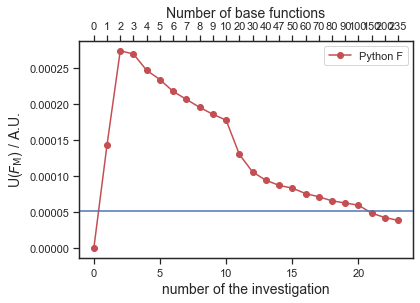

In [19]:
lines =petriTableSMCF.shape[0]
eval=np.zeros((lines, 5))
eval[:,0]=petriTableSMCF["N"].to_numpy().T
eval[:,1]=petriTableSMCF["SMCF_M_95%"].to_numpy().T
xNumber = range(lines)
fig = pyplot.figure()
ax1 = fig.add_subplot(111)
ax2 = ax1.twiny()
ax1.set_xlabel(r"number of the investigation",fontsize=label_font_size)
ax1.set_ylabel('U($F_\mathrm{M}$) / A.U.',fontsize=label_font_size)
ax1.plot(xNumber, eval[:,1], 'r-o', label='Python F')
pyplot.axhline(5.1562451138464915e-05)
new_tick_locations = range( lines)
def tick_function(X):
    return ["%d" % elements2Run[z] for z in X]
ax2.set_xlim(ax1.get_xlim())
ax2.set_xticks(new_tick_locations)
ax2.set_xticklabels(tick_function(new_tick_locations))
ax2.set_xlabel(r"Number of base functions",fontsize=label_font_size)
ax1.legend()
ax1.grid(False)
ax2.grid(False)
save_fig(out_dir, 'SMCF_M_Table1')